In [1]:
# For iPython notebook
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
#matplotlib.rc('font', **font)

### DATA IMPORT ###
# training
gen = pd.read_csv("training/Training_Genetic_Dataset.csv")
pfrm = pd.read_csv("training/Training_Performance_Dataset.csv")
soil = pd.read_csv("training/Training_Soil_Dataset.csv")
wtr = pd.read_csv("training/Training_Weather_Dataset.csv")

# validation
pfrm_v = pd.read_csv("training/Validation_Performance_Dataset.csv")

In [39]:
# for Performance
def fe4pfrm(pfrm):
    p1 = pfrm.Hybrid.str[0:5]
    p2 = pfrm.Hybrid.str[6:11]
    p1_df = p1.to_frame(name='p1')
    p2_df = p2.to_frame(name='p2')

    # Normalize Lat and Lon
    latlon_norm = pfrm[['Latitude', 'Longitude']].apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    latlon_norm = latlon_norm.rename(columns={'Latitude': 'Lat_n', 'Longitude': 'Lon_n'})
    #latlon_norm['lat_n_pow'] = latlon_norm['Lat_n'] ** 2
    #latlon_norm['lon_n_pow'] = latlon_norm['Lon_n'] ** 2
    
    #latlon_norm = pfrm[['Latitude', 'Longitude']]
    #pfrm_drp = pfrm.drop(['Latitude', 'Longitude'], axis=1)

    mrg = pd.concat([pfrm, p1_df, p2_df, latlon_norm], axis=1, join_axes=[pfrm.index])
    mrg_drp = mrg.drop(['Yield', 'Check_Yield'], axis=1)
    # One-hot Encoding
    p1_hot = pd.get_dummies(mrg_drp, prefix ='', prefix_sep='', columns=['p1'])
    p2_hot = pd.get_dummies(mrg_drp, prefix ='', prefix_sep='', columns=['p2'])
    p1_drp = p1_hot.drop(['Hybrid', 'Year', 'Maturity_Group', 'Location_ID', 'Latitude', 'Longitude', 'Lat_n', 'Lon_n', 'Yield_Difference', 'HighV_Flag', 'p2'], axis=1)
    p2_drp = p2_hot.drop(['Hybrid', 'Year', 'Maturity_Group', 'Location_ID', 'Latitude', 'Longitude', 'Lat_n', 'Lon_n', 'Yield_Difference', 'HighV_Flag', 'p1'], axis=1)
    parents_df = p1_drp.add(p2_drp, fill_value=0).astype(int)

    # Merge parents_df
    mrg_drp_seed = mrg_drp.drop(['Hybrid', 'p1', 'p2'], axis=1)
    mrg_drp_seed['M_Group_pow'] = mrg_drp_seed.Maturity_Group ** 2
    out = pd.concat([mrg_drp_seed, parents_df], axis=1)
    return out

# for Weather
def fe4wtr(wtr):
    # Chose May-October
    # Calc Rate of Change between month
    w_vars = []
    for i in range(1, 7):
        for m in range(5, 11): # Corn grow from May to October 5, 10
            w_vars.append('w_' + str(i) + '_' + str(m))
    wtr_sbt = wtr[['Location_ID', 'Year'] + w_vars]
    for i in range(1, 7):
        # initialize sum list
        wtr_i_sum = wtr['w_' + str(i) + '_4']
        for m in range(5, 11): # Corn grow from May to October 5, 10
            wtr_sbt = wtr_sbt.join(pd.DataFrame(wtr['w_' + str(i) + '_' + str(m + 1)] - wtr['w_' + str(i) + '_' + str(m)], columns=['w_' + str(i) + '_' + str(m + 1) + 'minus' + str(m)]))
            wtr_sbt = wtr_sbt.join(pd.DataFrame(wtr['w_' + str(i) + '_' + str(m + 1)] * wtr['w_' + str(i) + '_' + str(m)], columns=['w_' + str(i) + '_' + str(m + 1) + 'multi' + str(m)]))
            wtr_sbt['w_' + str(i) + '_' + str(m) + 'pow'] = wtr['w_' + str(i) + '_' + str(m)] **2
            wtr_i_sum += wtr['w_' + str(i) + '_' + str(m)]
        wtr_i_mean = wtr_i_sum / 12
        wtr_sbt = wtr_sbt.join(wtr_i_sum.rename('w_sum_' + str(i)))
        wtr_sbt = wtr_sbt.join(wtr_i_mean.rename('w_mean_' + str(i)))
    return wtr_sbt

# for Soil
def fe4soil(soil):
    # Drop Latitude and Longitude
    soil_drp = soil.drop(['Latitude', 'Longitude'], axis=1)
    var_list = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8']
    for v in var_list:
        soil_drp[v + 'pow'] = soil_drp[v] ** 2
    return soil_drp

# Add flag of high variance hybrid pair
def hybrid_var_flagger(df_in):
    # calc variance under same Hybrid pair, same Year, and same Location_ID
    df = df_in[['Hybrid', 'Year', 'Location_ID', 'Yield_Difference']]
    df = df[df.Year < 2016]
    # variance of each combination
    each_var = df.groupby(['Hybrid', 'Year', 'Location_ID'])['Yield_Difference'].var()
    # variance of each
    each_var_drpna = pd.DataFrame(each_var.dropna()).reset_index()
    each_hybrid_var_mean = each_var_drpna.groupby(['Hybrid'])['Yield_Difference'].mean()
    # threshhold of high variance
    th = each_hybrid_var_mean.describe()[3] # 6: 75%tile, 5: 50%tile, 4: 25%tile, 3: ALL

    # Sort
    df_sorted = pd.DataFrame(each_hybrid_var_mean.sort_values(ascending=False)).reset_index()
    df_sorted.to_csv('hybrid_variance.csv')

    # High Variance: 1, Low Variance: 0
    df_sorted['HighV_Flag'] = df_sorted['Yield_Difference'].apply(lambda x: 1 if x > th else 0)
    df_sorted = df_sorted.drop(['Yield_Difference'], axis=1)
    
    # merge the flag and return
    out = pd.merge(df_in, df_sorted, on=['Hybrid'], how='left')
    # the define of only once appeared seed hybrid
    # 1: classify as high variance, 0: classify as low variance
    out = out.fillna(value = 0)
    #out = out.fillna(value = 1)
    return out

# Merge Performance, Soil, Weather
def mrg(pfrm, wtr, soil):
    mrg_pf_soil = pd.merge(pfrm, soil, on=['Location_ID'])
    mrg_pf_soil_wtr = pd.merge(mrg_pf_soil, wtr, on=['Location_ID', 'Year'])
    mrg_pf_soil_wtr_drp = mrg_pf_soil_wtr.drop(['Location_ID'], axis=1)
    return mrg_pf_soil_wtr_drp

In [76]:
# train
# variance flag
pfrm_flg = hybrid_var_flagger(pfrm)
pfrm_df = fe4pfrm(pfrm_flg)
wtr_df = fe4wtr(wtr)
soil_df = fe4soil(soil)

train_df_y = mrg(pfrm_df, wtr_df, soil_df)
train_df = train_df_y.drop(['Year'], axis=1)

In [135]:
# get rid of outliers
train_df_full = train_df_y
train_df_y = train_df_y[train_df_y.Yield_Difference > -37.500487]
train_df_y = train_df_y[train_df_y.Yield_Difference < 9.539052]

In [78]:
# non outliers dataset
#df = train_df_y[train_df.HighV_Flag == 0.0]
df = train_df_y
df_train = df[df.Year < 2016].drop(['Year'], axis = 1)
df_train = df_train[df_train.HighV_Flag == 0.0].drop(['HighV_Flag'], axis=1)
#df_valid = df[df.Year == 2016].drop(['Year', 'HighV_Flag'], axis = 1)
df_valid = df[df.Year == 2016].drop(['Year'], axis = 1)
df_valid = df_valid[df_valid.HighV_Flag == 0.0].drop(['HighV_Flag'], axis=1)

X_train = df_train.drop(['Yield_Difference'], axis = 1).iloc[:, :].values
X_test = df_valid.drop(['Yield_Difference'], axis = 1).iloc[:, :].values
y_train = df_train.loc[:, 'Yield_Difference'].values
y_test = df_valid.loc[:, 'Yield_Difference'].values

In [79]:
# w/ outliners dataset
#df = train_df_y[train_df.HighV_Flag == 0.0]
df = train_df_full
df_train_f = df[df.Year < 2016].drop(['Year'], axis = 1)
df_train_f = df_train_f[df_train_f.HighV_Flag == 0.0].drop(['HighV_Flag'], axis=1)
#df_valid = df[df.Year == 2016].drop(['Year', 'HighV_Flag'], axis = 1)
df_valid_f = df[df.Year == 2016].drop(['Year'], axis = 1)
df_valid_f = df_valid_f[df_valid_f.HighV_Flag == 0.0].drop(['HighV_Flag'], axis=1)

X_train_f = df_train_f.drop(['Yield_Difference'], axis = 1).iloc[:, :].values
X_test_f = df_valid_f.drop(['Yield_Difference'], axis = 1).iloc[:, :].values
y_train_f = df_train_f.loc[:, 'Yield_Difference'].values
y_test_f = df_valid_f.loc[:, 'Yield_Difference'].values

In [278]:
df_valid.shape

(840, 1704)

In [22]:
base_rmse = ((((df_valid.Yield_Difference - df_train.Yield_Difference.mean())**2).sum())*(1/len(df_valid.index)))**(1/2)
base_rmse

12.131393882719346

In [246]:
len(y_test)

21194

In [250]:
xgb_rmse = ((((y_test - y_test_pred)**2).sum())*(1/len(y_test)))**(1/2)
xgb_rmse

12.592982692095713

In [71]:
# RMSE of unsumble model
df_hv = train_df[train_df.HighV_Flag == 1]
avg_rmse = ((((df_hv.Yield_Difference - df_hv.Yield_Difference.mean())**2).sum())*(1/len(df_hv.index)))**(1/2) 
hv_sample = df_hv.shape[0]
lv_sample = df.shape[0]
((lv_sample * 11.664) + (hv_sample * avg_rmse)) / (lv_sample + hv_sample)

In [82]:
((lv_sample * 11.664) + (hv_sample * 16.639)) / (lv_sample + hv_sample)

12.792968404303682

In [54]:
df.to_csv("train_set.csv")

In [178]:
# Split Dataset for Train and Validation
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.1, random_state=0)

In [73]:
# Import Library of Randam Forest Reg
from sklearn.ensemble import RandomForestRegressor
# Using vanilla parameters
forest = RandomForestRegressor()
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [74]:
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
importances = forest.feature_importances_

In [75]:
# RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
print('RMSE train : %.3f, test : %.3f' % (sqrt(mean_squared_error(y_train, y_train_pred)), sqrt(mean_squared_error(y_test, y_test_pred))))
# R^2
from sklearn.metrics import r2_score
print('R2 train : %.3f, test : %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

RMSE train : 3.625, test : 11.170
R2 train : 0.858, test : -0.341


In [216]:
imp_df = pd.DataFrame({'var': df_train.columns, 'var_importances': importances})
imp_df.sort_values(by=['var_importances'], ascending=False)
#for i in range(len(x_df.columns)):
#    print(x_df.columns[i], ': ', importances[i])

ValueError: arrays must all be same length

In [9]:
# Grid Search
from sklearn.grid_search import GridSearchCV
# Parameter (the number of trees)
params = {'n_estimators'  : [3, 10, 100], 'n_jobs': [-1]}

# Model instance
mod = RandomForestRegressor()
# Grid Search
cv = GridSearchCV(mod, params, cv = 10, scoring= 'neg_mean_squared_error', n_jobs=1, verbose=2)
cv.fit(X_train, y_train)

/Users/isaac/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


NameError: name 'RandomForestRegressor' is not defined

In [227]:
import xgboost as xgb

In [228]:
# Model Instance
mod = xgb.XGBRegressor()
mod.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [247]:
y_train_pred = mod.predict(X_train)
y_test_pred = mod.predict(X_test)
print('RMSE train : %.3f, test : %.3f' % (sqrt(mean_squared_error(y_train, y_train_pred)), sqrt(mean_squared_error(y_test, y_test_pred))))
# R^2
from sklearn.metrics import r2_score
print('R2 train : %.3f, test : %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

XGBoostError: need to call fit beforehand

In [303]:
from sklearn.grid_search import GridSearchCV
# Parameter for XGBoost
params = {'max_depth': [10],
          'min_child_weight': [1],
          'gamma': [0],
          'learning_rate': [0.05, 0.08, 0.1],
          'subsample': [0.5, 0.8, 1.0],
          'colsample_bytree': [0.2, 0.5, 0.8]}
# Model Instance
mod = xgb.XGBRegressor()
# 10-fold Cross Validation
cv = GridSearchCV(mod, params, cv=10, scoring='neg_mean_squared_error', n_jobs=1, verbose=2)
cv.fit(X_train, y_train)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
[CV] learning_rate=0.05, colsample_bytree=0.2, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.05, colsample_bytree=0.2, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 -  34.6s
[CV] learning_rate=0.05, colsample_bytree=0.2, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.6s remaining:    0.0s


[CV]  learning_rate=0.05, colsample_bytree=0.2, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 -  33.8s
[CV] learning_rate=0.05, colsample_bytree=0.2, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.05, colsample_bytree=0.2, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 -  33.6s
[CV] learning_rate=0.05, colsample_bytree=0.2, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.05, colsample_bytree=0.2, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 -  33.5s
[CV] learning_rate=0.05, colsample_bytree=0.2, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.05, colsample_bytree=0.2, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 -  33.8s
[CV] learning_rate=0.05, colsample_bytree=0.2, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.05, colsample_bytree=0.2, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 -  33.5s
[CV] learn

[CV]  learning_rate=0.08, colsample_bytree=0.2, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 -  32.8s
[CV] learning_rate=0.08, colsample_bytree=0.2, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.08, colsample_bytree=0.2, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 -  30.2s
[CV] learning_rate=0.08, colsample_bytree=0.2, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.08, colsample_bytree=0.2, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 -  30.2s
[CV] learning_rate=0.08, colsample_bytree=0.2, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.08, colsample_bytree=0.2, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 -  30.2s
[CV] learning_rate=0.08, colsample_bytree=0.2, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.08, colsample_bytree=0.2, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 -  30.4s
[CV] learn

[CV]  learning_rate=0.1, colsample_bytree=0.2, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 -  30.2s
[CV] learning_rate=0.1, colsample_bytree=0.2, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.1, colsample_bytree=0.2, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 -  30.0s
[CV] learning_rate=0.1, colsample_bytree=0.2, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.1, colsample_bytree=0.2, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 -  30.0s
[CV] learning_rate=0.1, colsample_bytree=0.2, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.1, colsample_bytree=0.2, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 -  27.2s
[CV] learning_rate=0.1, colsample_bytree=0.2, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.1, colsample_bytree=0.2, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 -  27.1s
[CV] learning_rate=

[CV]  learning_rate=0.05, colsample_bytree=0.5, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 -  53.4s
[CV] learning_rate=0.05, colsample_bytree=0.5, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.05, colsample_bytree=0.5, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 -  53.5s
[CV] learning_rate=0.05, colsample_bytree=0.5, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.05, colsample_bytree=0.5, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 -  53.5s
[CV] learning_rate=0.05, colsample_bytree=0.5, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.05, colsample_bytree=0.5, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 -  53.3s
[CV] learning_rate=0.05, colsample_bytree=0.5, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.05, colsample_bytree=0.5, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 -  53.6s
[CV] learn

[CV]  learning_rate=0.1, colsample_bytree=0.5, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 - 1.1min
[CV] learning_rate=0.1, colsample_bytree=0.5, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.1, colsample_bytree=0.5, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 - 1.1min
[CV] learning_rate=0.1, colsample_bytree=0.5, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.1, colsample_bytree=0.5, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 - 1.1min
[CV] learning_rate=0.1, colsample_bytree=0.5, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.1, colsample_bytree=0.5, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 - 1.1min
[CV] learning_rate=0.1, colsample_bytree=0.5, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.1, colsample_bytree=0.5, subsample=0.5, gamma=0, max_depth=10, min_child_weight=1 - 1.1min
[CV] learning_rate=

[CV]  learning_rate=0.05, colsample_bytree=0.8, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 - 1.5min
[CV] learning_rate=0.05, colsample_bytree=0.8, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.05, colsample_bytree=0.8, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 - 1.5min
[CV] learning_rate=0.05, colsample_bytree=0.8, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.05, colsample_bytree=0.8, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 - 1.5min
[CV] learning_rate=0.05, colsample_bytree=0.8, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.05, colsample_bytree=0.8, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 - 1.5min
[CV] learning_rate=0.05, colsample_bytree=0.8, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.05, colsample_bytree=0.8, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 - 1.5min
[CV] learn

[CV]  learning_rate=0.08, colsample_bytree=0.8, subsample=0.8, gamma=0, max_depth=10, min_child_weight=1 - 1.5min
[CV] learning_rate=0.08, colsample_bytree=0.8, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.08, colsample_bytree=0.8, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 - 1.3min
[CV] learning_rate=0.08, colsample_bytree=0.8, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.08, colsample_bytree=0.8, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 - 1.3min
[CV] learning_rate=0.08, colsample_bytree=0.8, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.08, colsample_bytree=0.8, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 - 1.3min
[CV] learning_rate=0.08, colsample_bytree=0.8, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.08, colsample_bytree=0.8, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 - 1.3min
[CV] learn

[CV]  learning_rate=0.1, colsample_bytree=0.8, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 - 1.3min
[CV] learning_rate=0.1, colsample_bytree=0.8, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.1, colsample_bytree=0.8, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 - 1.3min
[CV] learning_rate=0.1, colsample_bytree=0.8, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 
[CV]  learning_rate=0.1, colsample_bytree=0.8, subsample=1.0, gamma=0, max_depth=10, min_child_weight=1 - 1.3min


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 271.5min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.05, 0.08, 0.1], 'colsample_bytree': [0.2, 0.5, 0.8], 'subsample': [0.5, 0.8, 1.0], 'min_child_weight': [1], 'max_depth': [10], 'gamma': [0]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=2)

In [304]:
from sklearn.metrics import mean_squared_error
from math import sqrt
y_train_pred = cv.predict(X_train)
y_test_pred = cv.predict(X_test)
#importances = cv.importances_
print('RMSE train : %.3f, test : %.3f' % (sqrt(mean_squared_error(y_train, y_train_pred)), sqrt(mean_squared_error(y_test, y_test_pred))))
# R^2
from sklearn.metrics import r2_score
print('R2 train : %.3f, test : %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

RMSE train : 11.587, test : 12.487
R2 train : 0.357, test : -0.171


In [232]:
cv.best_estimator_

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.08, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.5)

(-150, 150)

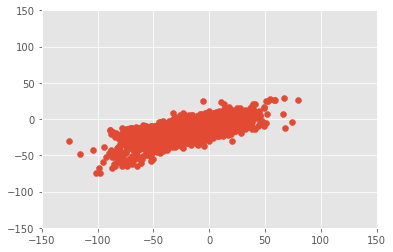

In [306]:
plt.scatter(y_train, y_train_pred)
plt.xlim([-150, 150])
plt.ylim([-150, 150])

(-150, 150)

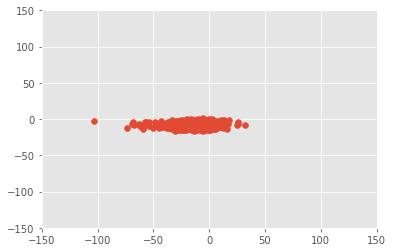

In [307]:
plt.scatter(y_test, y_test_pred)
plt.xlim([-150, 150])
plt.ylim([-150, 150])

In [22]:
best_par_mod = xgb.XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
                   gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
                   min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
                   objective='reg:linear', reg_alpha=0, reg_lambda=1,
                   scale_pos_weight=1, seed=0, silent=True, subsample=0.8)
best_par_mod.fit(X_train, y_train)

y_train_pred = best_par_mod.predict(X_train)
y_test_pred = best_par_mod.predict(X_test)
print('RMSE train : %.3f, test : %.3f' % (sqrt(mean_squared_error(y_train, y_train_pred)), sqrt(mean_squared_error(y_test, y_test_pred))))
# R^2
from sklearn.metrics import r2_score
print('R2 train : %.3f, test : %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

AttributeError: 'XGBRegressor' object has no attribute 'importances_'

In [16]:
imp_df = pd.DataFrame({'var': x_df.columns, 'var_importances': importances})
imp_df.sort_values(by=['var_importances'], ascending=False)

NameError: name 'importances' is not defined

In [19]:
gen.isnull().sum().describe()

count    19466.000000
mean       850.570687
std        732.134131
min          0.000000
25%        469.000000
50%        547.000000
75%       1554.000000
max       2140.000000
dtype: float64

(array([  366.,   318.,   287.,  1086.,   972.,   392.,   253.,   103.,
           86.,    56.,    40.,    39.,    66.,    75.,   113.,   120.,
           95.,    95.,    74.,    62.,    86.,    86.,   285.,   286.,
         2187.,  3293.,  1341.,   369.,   297.,   266.,   189.,   110.,
          103.,    32.,    20.,    12.,    13.,    21.,    16.,    14.,
           17.,    26.,    25.,    23.,    19.,    15.,    40.,    50.,
           46.,    42.,    58.,    46.,    44.,    25.,    22.,    12.,
            7.,    11.,    16.,    14.,    13.,    28.,    14.,    16.,
           17.,    12.,    11.,    12.,    21.,    44.,    43.,    46.,
           61.,    20.,    32.,    27.,    11.,    21.,    15.,    17.,
           11.,    17.,    24.,    35.,    81.,    55.,    41.,    52.,
           70.,    79.,    53.,    29.,    18.,    33.,   104.,    57.,
         2551.,   514.,   108.,   771.]),
 array([    0. ,    21.4,    42.8,    64.2,    85.6,   107. ,   128.4,
          149.8,   171.

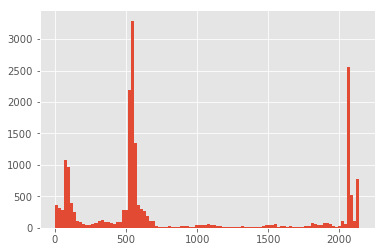

In [29]:
plt.hist(gen.isnull().sum(), bins=100)

In [146]:
pfrm_v

,Hybrid,Year,Maturity_Group,Location_ID,Latitude,Longitude
0,P1000:P2030,2016,8,2113,36.29419,-76.31354
1,P1000:P2030,2016,8,2244,28.78775,-96.84418
2,P1000:P2030,2016,8,2241,32.87210,-82.21630
3,P1000:P2030,2016,8,2247,29.21960,-95.99060
4,P1000:P2030,2016,8,2235,30.54635,-96.43408
5,P1000:P2030,2016,8,2239,32.03723,-84.37050
6,P1000:P2030,2016,8,2110,38.09612,-76.72440
7,P1000:P2030,2016,8,2240,32.03097,-96.92797
8,P1000:P2030,2016,8,2242,26.24660,-97.77882
9,P1000:P2030,2016,8,2236,32.28267,-96.68421


In [308]:
# SGD regressor
from sklearn import cross_validation, preprocessing, linear_model
clf = linear_model.SGDRegressor()
clf.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [309]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print('RMSE train : %.3f, test : %.3f' % (sqrt(mean_squared_error(y_train, y_train_pred)), sqrt(mean_squared_error(y_test, y_test_pred))))
# R^2
from sklearn.metrics import r2_score
print('R2 train : %.3f, test : %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

RMSE train : 5697823428836453.000, test : 5274071600091617.000
R2 train : -155463046253680888238883995648.000, test : -208833398395846795989291630592.000


In [7]:
# SVR
from sklearn.svm import SVR
import numpy as np
from sklearn.grid_search import GridSearchCV
#svr_mod = SVR(C=1.0, epsilon=0.2)
#svr_mod.fit(X_train, y_train) 

/Users/isaac/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/isaac/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [ ]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [10**i for i in range(-4, 0)],
                         'C': [10**i for i in range(1,4)]}]
svr_mod = GridSearchCV(
    SVR(), # 識別器
    tuned_parameters, # 最適化したいパラメータセット 
    cv=5, # 交差検定の回数
    scoring="mean_squared_error", # モデルの評価関数の指定
     n_jobs=1, verbose=2)
svr_mod.fit(X_train, y_train) 

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] C=10, kernel=rbf, gamma=0.0001 ..................................


/Users/isaac/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ........................ C=10, kernel=rbf, gamma=0.0001 -117.9min
[CV] C=10, kernel=rbf, gamma=0.0001 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 117.9min remaining:    0.0s
/Users/isaac/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ........................ C=10, kernel=rbf, gamma=0.0001 -124.5min
[CV] C=10, kernel=rbf, gamma=0.0001 ..................................


In [38]:
y_train

array([-12.64633   , -14.9326    ,   1.788433  , ...,   6.956833  ,
        -4.43463333, -24.31516667])

In [39]:
y_train_pred

array([  3.44461870e+11,   4.60008378e+11,   7.17370171e+10, ...,
         7.88066065e+11,   4.00661633e+11,   2.33510193e+11])

In [41]:
### Data Aggregation based on
def hybrid_var_flagger(df):
    # calc variance under same Hybrid pair, same Year, and same Location_ID
    df = df[['Hybrid', 'Year', 'Location_ID', 'Yield_Difference']]
    # variance of each combination
    each_var = df.groupby(['Hybrid', 'Year', 'Location_ID'])['Yield_Difference'].var()
    # variance of each 
    each_var_drp_na = pd.DataFrame(each_var.dropna()).reset_index(inplace=True)
    each_hybrid_var_mean = each_var_drp_na.groupby(['Hybrid'])['Yield_Difference'].mean()
    
    # Sort
    df_sorted = each_hybrid_var_mean.sort_values(by=['Yield_Difference'], ascending=False)
    df_sorted.write_csv('Hybrid_variance_rank.csv')

    # Describe and set criteria
    print(df_sorted['Yield_Difference'].describe)
    #criteria = df_sorted['Yield_Difference'].describe!!!75%tile??
    # Targetting
    # High Variance: 1, Low Variance: 0
    #df_sorted['HighV_Flag'] = df_sorted['Yield_Difference'].apply(lambda x: 1 if x > 100 else 0)

    # merge the flag and return
    #out = df.merge(df_sorted['HighV_Flag'], key='Hybrid')
    #return df_sorted

In [49]:
df = pfrm
df = df[['Hybrid', 'Year', 'Location_ID', 'Yield_Difference']]
# variance of each combination
each_var = df.groupby(['Hybrid', 'Year', 'Location_ID'])['Yield_Difference'].var()
# variance of each 
#each_var_drp_na = pd.DataFrame(each_var.dropna()).reset_index(inplace=True)
#each_hybrid_var_mean = each_var_drp_na.groupby(['Hybrid'])['Yield_Difference'].mean()

In [65]:
each_var_drpna = pd.DataFrame(each_var.dropna()).reset_index()

In [66]:
each_hybrid_var_mean = each_var_drpna.groupby(['Hybrid'])['Yield_Difference'].mean()

In [77]:
df_sorted = each_hybrid_var_mean.sort_values(ascending=False)

In [78]:
df_sorted.to_csv('hybrid_variance.csv')

In [81]:
df_sorted = pd.DataFrame(df_sorted).reset_index()

In [90]:
df_sorted['HighV_Flag'] = df_sorted['Yield_Difference'].apply(lambda x: 1 if x > 1000 else 0)

In [91]:
out = pd.merge(pfrm, df_sorted, on=['Hybrid'])

In [92]:
out

,Hybrid,Year,Maturity_Group,Location_ID,Latitude,Longitude,Yield,Check_Yield,Yield_Difference_x,Yield_Difference_y,HighV_Flag
0,P1002:P1158,2014,8,1585,40.27221,-100.74510,141.0642,170.35200,-29.287770,205.317857,0
1,P1002:P1158,2014,7,1586,40.93688,-97.02449,76.1254,127.38850,-51.263070,205.317857,0
2,P1002:P1158,2014,8,1554,36.11868,-102.92160,169.7310,180.46870,-10.737730,205.317857,0
3,P1002:P1158,2014,7,1555,40.74230,-97.24827,130.8370,156.17530,-25.338330,205.317857,0
4,P1002:P1158,2014,7,1561,35.08770,-102.19630,190.0762,186.19680,3.879367,205.317857,0
5,P1002:P1158,2014,8,1557,39.51870,-89.13775,134.8357,163.16780,-28.332100,205.317857,0
6,P1002:P1158,2014,8,1586,40.93688,-97.02449,112.8939,134.80480,-21.910900,205.317857,0
7,P1002:P1158,2014,7,1538,36.66522,-76.72889,102.3847,130.18100,-27.796270,205.317857,0
8,P1002:P1158,2014,7,1585,40.27221,-100.74510,121.9931,170.62230,-48.629230,205.317857,0
9,P1002:P1158,2014,7,1546,29.22160,-95.99766,60.3367,77.01617,-16.679470,205.317857,0


In [138]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'auc'},
    'num_leaves': 80,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'verbose': 0
}

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=10
               )

print('Save model...')
# save model to file
gbm.save_model('model.txt')

print('Start predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_f = gbm.predict(X_test_f, num_iteration=gbm.best_iteration)
y_pred_17 = gbm.predict(X_17_f, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
print('The rmse w/ outlers of prediction is:', mean_squared_error(y_test_f, y_pred_f) ** 0.5)

Start training...
[1]	valid_0's l2: 93.7821	valid_0's auc: 0.510302
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 93.8141	valid_0's auc: 0.524604
[3]	valid_0's l2: 93.8775	valid_0's auc: 0.525658
[4]	valid_0's l2: 93.9006	valid_0's auc: 0.518513
[5]	valid_0's l2: 93.9661	valid_0's auc: 0.524029
[6]	valid_0's l2: 94.0323	valid_0's auc: 0.523629
[7]	valid_0's l2: 94.0656	valid_0's auc: 0.518274
[8]	valid_0's l2: 94.1021	valid_0's auc: 0.515235
[9]	valid_0's l2: 94.1683	valid_0's auc: 0.509693
[10]	valid_0's l2: 94.2036	valid_0's auc: 0.506877
[11]	valid_0's l2: 94.2498	valid_0's auc: 0.507408
Early stopping, best iteration is:
[1]	valid_0's l2: 93.7821	valid_0's auc: 0.510302
Save model...
Start predicting...
The rmse of prediction is: 9.68411741294
The rmse w/ outlers of prediction is: 9.67836530518


In [38]:
pfrm_flg[pfrm_flg.HighV_Flag==1.0].to_csv('high_var.csv')

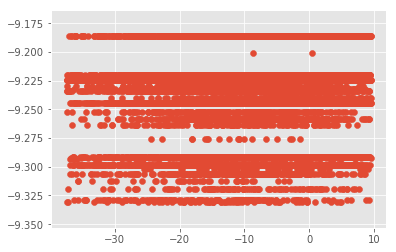

In [72]:
plt.scatter(y_test, y_pred)
#plt.xlim([-9.0, -8.5])
#plt.ylim([-9.0, -8.5])

In [65]:
pfrm.Yield_Difference.describe(percentiles=[.05, .25, .5, .75, .95])

count    148452.000000
mean        -11.765007
std          14.725981
min        -128.236600
5%          -37.500487
25%         -19.491032
50%         -10.514030
75%          -2.529467
95%           9.539052
max         107.328700
Name: Yield_Difference, dtype: float64

In [57]:
pd.Series(y_test).describe()

count    17783.000000
mean       -10.064351
std         12.062950
min       -123.681000
25%        -16.614415
50%         -9.232400
75%         -2.407700
max         73.467230
dtype: float64

In [112]:
# testing at 2017
pfrm_t = pd.read_csv("test/Test_Performance_Dataset.csv")
soil_t = pd.read_csv("test/Test_Soil_Dataset.csv")
wtr_t = pd.read_csv("test/Test_Weather_Predicted.csv")
wtr_t['Year'] = 2017

In [113]:
# for Performance
def fe4pfrm_t(pfrm):
    p1 = pfrm.Hybrid.str[0:5]
    p2 = pfrm.Hybrid.str[6:11]
    p1_df = p1.to_frame(name='p1')
    p2_df = p2.to_frame(name='p2')

    # Normalize Lat and Lon
    latlon_norm = pfrm[['Latitude', 'Longitude']].apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    latlon_norm = latlon_norm.rename(columns={'Latitude': 'Lat_n', 'Longitude': 'Lon_n'})
    #latlon_norm['lat_n_pow'] = latlon_norm['Lat_n'] ** 2
    #latlon_norm['lon_n_pow'] = latlon_norm['Lon_n'] ** 2
    
    #latlon_norm = pfrm[['Latitude', 'Longitude']]
    #pfrm_drp = pfrm.drop(['Latitude', 'Longitude'], axis=1)

    mrg = pd.concat([pfrm, p1_df, p2_df, latlon_norm], axis=1, join_axes=[pfrm.index])
    mrg_drp = mrg#.drop(['Yield', 'Check_Yield'], axis=1)
    # One-hot Encoding
    p1_hot = pd.get_dummies(mrg_drp, prefix ='', prefix_sep='', columns=['p1'])
    p2_hot = pd.get_dummies(mrg_drp, prefix ='', prefix_sep='', columns=['p2'])
    p1_drp = p1_hot.drop(['Hybrid', 'Year', 'Maturity_Group', 'Test_Location_ID', 'Latitude', 'Longitude', 'Lat_n', 'Lon_n', 'p2'], axis=1)
    p2_drp = p2_hot.drop(['Hybrid', 'Year', 'Maturity_Group', 'Test_Location_ID', 'Latitude', 'Longitude', 'Lat_n', 'Lon_n', 'p1'], axis=1)
    parents_df = p1_drp.add(p2_drp, fill_value=0).astype(int)

    # Merge parents_df
    mrg_drp_seed = mrg_drp.drop(['Hybrid', 'p1', 'p2'], axis=1)
    mrg_drp_seed['M_Group_pow'] = mrg_drp_seed.Maturity_Group ** 2
    out = pd.concat([mrg_drp_seed, parents_df], axis=1)
    return out

# for Weather
def fe4wtr_t(wtr):
    # Chose May-October
    # Calc Rate of Change between month
    w_vars = []
    for i in range(1, 7):
        for m in range(5, 11): # Corn grow from May to October 5, 10
            w_vars.append('w_' + str(i) + '_' + str(m))
    wtr_sbt = wtr[['Test_Location_ID', 'Year'] + w_vars]
    for i in range(1, 7):
        # initialize sum list
        wtr_i_sum = wtr['w_' + str(i) + '_4']
        for m in range(5, 11): # Corn grow from May to October 5, 10
            wtr_sbt = wtr_sbt.join(pd.DataFrame(wtr['w_' + str(i) + '_' + str(m + 1)] - wtr['w_' + str(i) + '_' + str(m)], columns=['w_' + str(i) + '_' + str(m + 1) + 'minus' + str(m)]))
            wtr_sbt = wtr_sbt.join(pd.DataFrame(wtr['w_' + str(i) + '_' + str(m + 1)] * wtr['w_' + str(i) + '_' + str(m)], columns=['w_' + str(i) + '_' + str(m + 1) + 'multi' + str(m)]))
            wtr_sbt['w_' + str(i) + '_' + str(m) + 'pow'] = wtr['w_' + str(i) + '_' + str(m)] **2
            wtr_i_sum += wtr['w_' + str(i) + '_' + str(m)]
        wtr_i_mean = wtr_i_sum / 12
        wtr_sbt = wtr_sbt.join(wtr_i_sum.rename('w_sum_' + str(i)))
        wtr_sbt = wtr_sbt.join(wtr_i_mean.rename('w_mean_' + str(i)))
    return wtr_sbt

# for Soil
def fe4soil_t(soil):
    # Drop Latitude and Longitude
    soil_drp = soil.drop(['Latitude', 'Longitude'], axis=1)
    var_list = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8']
    for v in var_list:
        soil_drp[v + 'pow'] = soil_drp[v] ** 2
    return soil_drp

# Merge Performance, Soil, Weather
def mrg_t(pfrm, wtr, soil):
    mrg_pf_soil = pd.merge(pfrm, soil, on=['Test_Location_ID'])
    mrg_pf_soil_wtr = pd.merge(mrg_pf_soil, wtr, on=['Test_Location_ID', 'Year'])
    mrg_pf_soil_wtr_drp = mrg_pf_soil_wtr.drop(['Test_Location_ID'], axis=1)
    return mrg_pf_soil_wtr_drp

In [115]:
# train
# variance flag
pfrm_df_t = fe4pfrm_t(pfrm_t)
wtr_df_t = fe4wtr_t(wtr_t)
soil_df_t = fe4soil(soil_t)

train_df_y_t = mrg_t(pfrm_df_t, wtr_df_t, soil_df_t)
#train_df_t = train_df_y.drop(['Year'], axis=1)

In [120]:
# w/ outliners dataset
#df = train_df_y[train_df.HighV_Flag == 0.0]
df_t = train_df_y_t.drop(['Year'], axis=1)
X_test_t = df_t.iloc[:,:].values

In [136]:
# Append 2017 dataset to past dataset
df = train_df_y.append(train_df_y_t).fillna(value=0)

In [137]:
# w/ outliners dataset
#df = train_df_y[train_df.HighV_Flag == 0.0]
#df = train_df_full
df_train_f = df[df.Year < 2017].drop(['Year'], axis = 1)
df_train_f = df_train_f[df_train_f.HighV_Flag == 0.0].drop(['HighV_Flag'], axis=1)
#df_valid = df[df.Year == 2016].drop(['Year', 'HighV_Flag'], axis = 1)
df_valid_f = df[df.Year == 2016].drop(['Year'], axis = 1)
df_valid_f = df_valid_f[df_valid_f.HighV_Flag == 0.0].drop(['HighV_Flag'], axis=1)

df_17_f = df[df.Year == 2017].drop(['Year', 'HighV_Flag'], axis = 1)

X_train_f = df_train_f.drop(['Yield_Difference'], axis = 1).iloc[:, :].values
X_test_f = df_valid_f.drop(['Yield_Difference'], axis = 1).iloc[:, :].values
y_train_f = df_train_f.loc[:, 'Yield_Difference'].values
y_test_f = df_valid_f.loc[:, 'Yield_Difference'].values

X_17_f = df_17_f.drop(['Yield_Difference'], axis = 1).iloc[:, :].values

In [139]:
pd.Series(y_pred_17).describe()

count    19826.000000
mean        -9.312245
std          0.006460
min         -9.312535
25%         -9.312535
50%         -9.312535
75%         -9.312535
max         -9.168576
dtype: float64

In [140]:
df_17_f['Predicted_Yield_Difference'] = pd.Series(y_pred_17)

In [146]:
result = df_17_f
#result = df_17_f[['Latitude', 'Longitude', 'Maturity_Group', 'Predicted_Yield_Difference']]

In [147]:
result.to_csv('Prediction2017.csv')